# Rosenbrock function

Rosenbrock function (2D):
$$
f(x, y) = (1 - x)^2 + 100 \cdot (y - x^2)^2
$$
- Global minimum: f(x, y) = 0 at (x, y) = (1, 1)
- Non-convex, commonly used to test optimization algorithms



In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import RK45
import adambash

In [30]:
# Rosenbrock function
def rosenbrock(x, y, a=1, b=100):
    return (a - x)**2 + b*(y - x**2)**2

In [31]:
# Initial point and optimization
x0 = np.array([-1, 2])
# Plot the Rosenbrock function and path
x = np.linspace(-2, 2, 400)
y = np.linspace(-1, 3, 400)
X, Y = np.meshgrid(x, y)
Z = rosenbrock(X, Y)

In [32]:
def prepPlot():
    plt.figure(figsize=(10, 6))
    levels = np.array([i**2 for i in range(20)])
    plt.contour(X, Y, Z, levels=levels, cmap='rainbow')
    plt.plot(1, 1, 'bo', label='Minimum (1,1)')
    plt.plot(-1,2,'co',label='Start')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Rosenbrock Function')
    plt.grid(True)

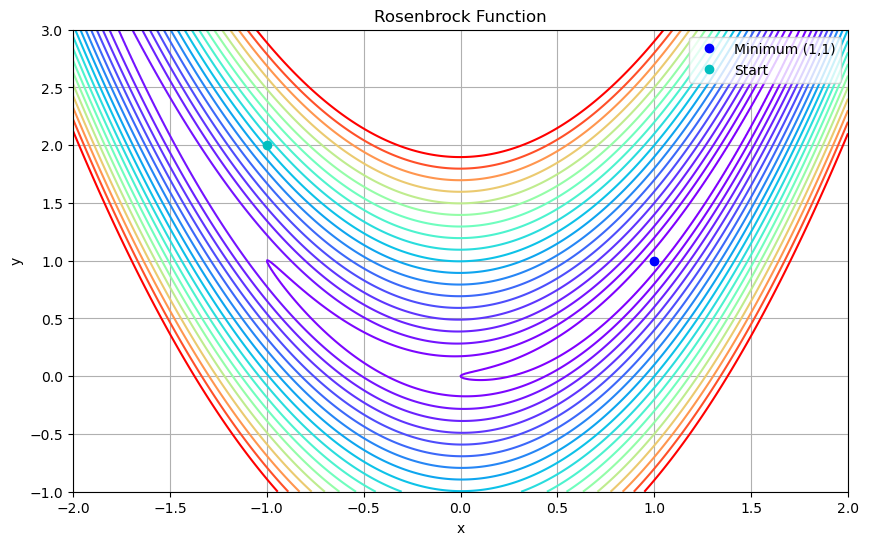

In [33]:
prepPlot()
plt.legend()
plt.show()

In [34]:
# Gradient of the Rosenbrock function
def grad_rosenbrock(xy, a=1, b=100):
    x, y = xy
    dx = -2*(a - x) - 4*b*x*(y - x**2)
    dy = 2*b*(y - x**2)
    return np.array([dx, dy])

In [35]:
# Steepest descent method
def steepest_descent(f_grad, x0, lr=0.001, max_iter=100, tol=1e-6):
    x = x0
    path = [x0.copy()]
    for i in range(max_iter):
        grad = f_grad(x)
        x_new = x - lr * grad
        if np.linalg.norm(x_new) > 20:
            break
        path.append(x_new.copy())
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new
    return np.array(path)

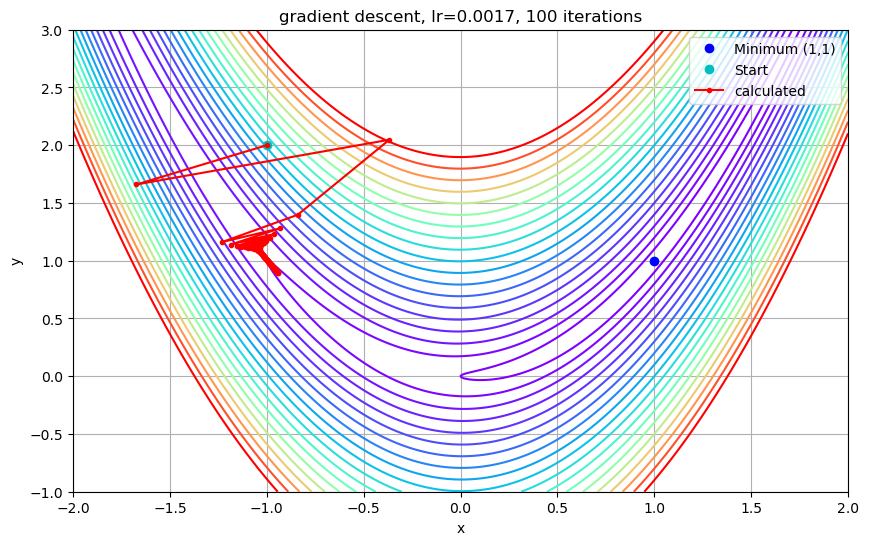

In [36]:
prepPlot()
path = steepest_descent(grad_rosenbrock, x0, lr=0.0017, max_iter=100)
plt.plot(path[:, 0], path[:, 1], 'r.-', label='calculated')
plt.title('gradient descent, lr=0.0017, 100 iterations')
plt.legend()
plt.show()

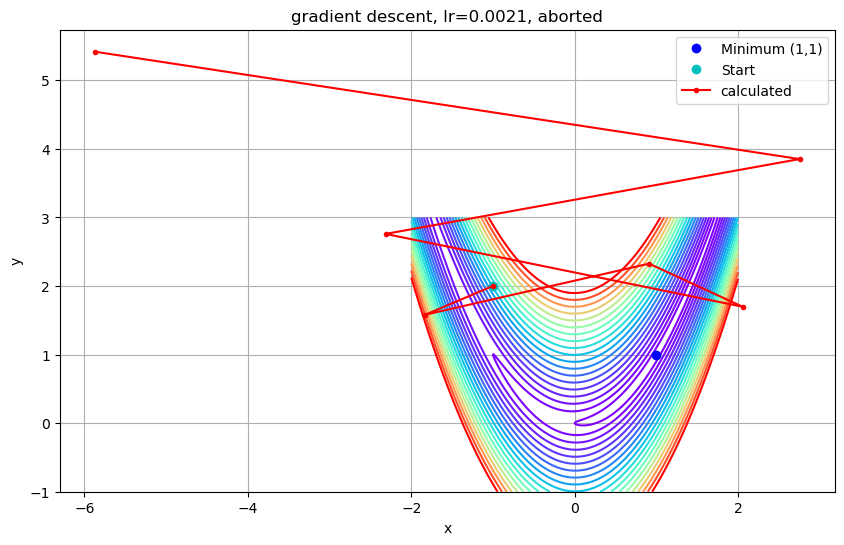

In [37]:
prepPlot()
path = steepest_descent(grad_rosenbrock, x0, lr=0.0021, max_iter=100)
plt.plot(path[:, 0], path[:, 1], 'r.-', label='calculated')
plt.title('gradient descent, lr=0.0021, aborted')
plt.legend()
plt.show()

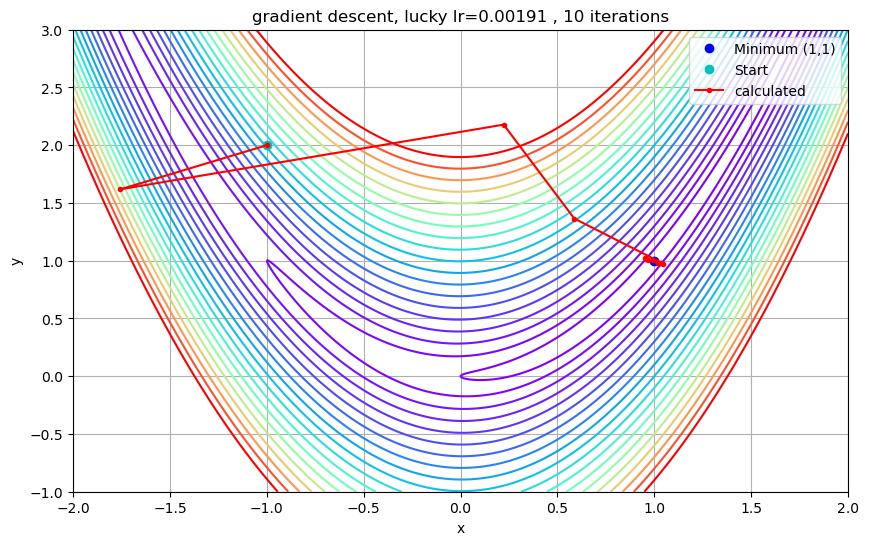

In [38]:
prepPlot()
path = steepest_descent(grad_rosenbrock, x0, lr=0.00191, max_iter=10)
plt.plot(path[:, 0], path[:, 1], 'r.-', label='calculated')
plt.title('gradient descent, lucky lr=0.00191 , 10 iterations')
plt.legend()
plt.show()

# Gradient flow

- need to change x according to the experienced gradient
$$ \dot{x} = f(t, x) $$

- can find the optimum by integrating to infinity
- integration method Runge-Kutta, with additional time parameter

In [43]:
def gradFlow(t,xy):
    xy_bar = -1 * grad_rosenbrock(xy, 1, 100)
    return xy_bar

In [44]:
def RKLpath(max_iter=10):
    rk45 = RK45(gradFlow,0,x0.copy(), 10,max_step=20000)
    path=[x0.copy()]
    for s in range(max_iter):
        rk45.step()
        path.append(rk45.y.copy())
    return np.array(path)

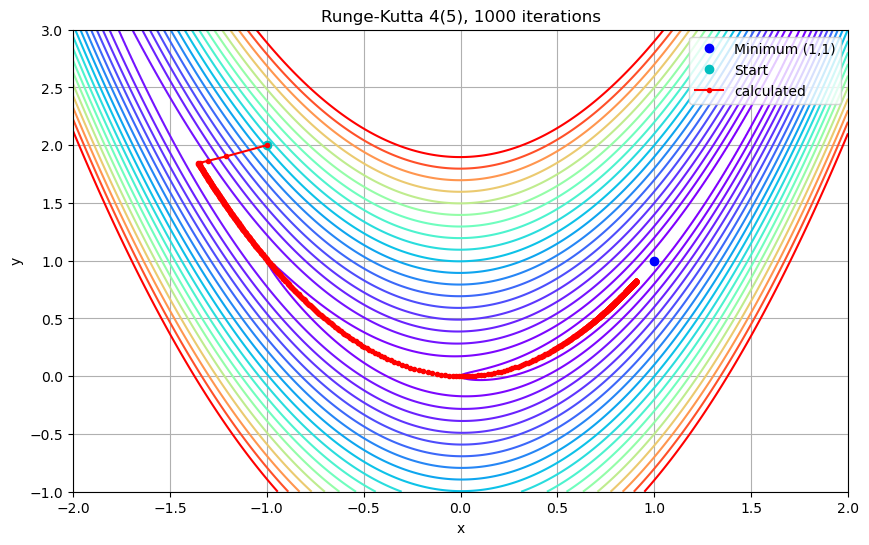

In [45]:
prepPlot()
# Solve using Runge-Kutta 4(5) (RK45)
path = RKLpath(1000)
plt.plot(path[:, 0], path[:, 1], 'r.-', label='calculated')
plt.title("Runge-Kutta 4(5), 1000 iterations")
plt.legend()
plt.show()

# Explicit higher order methods
- Adam Bashfort

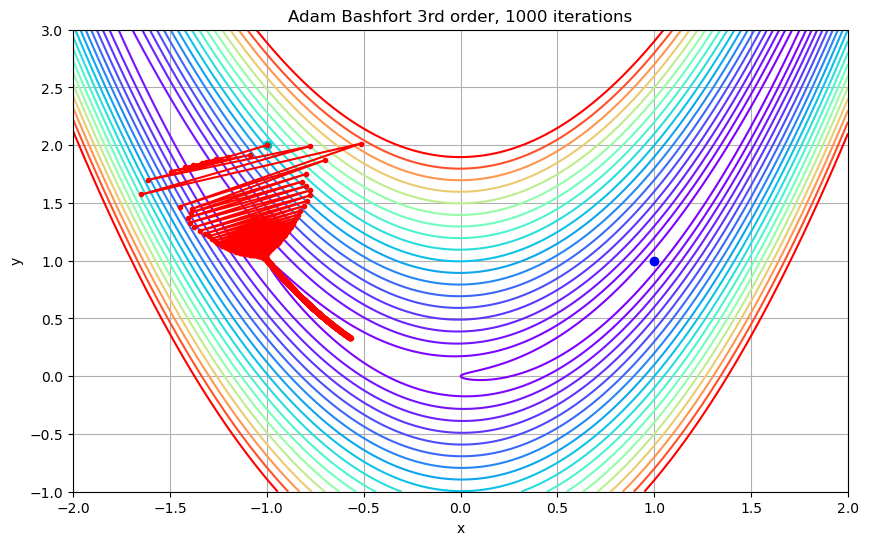

In [42]:
prepPlot()
ab= adambash.AdamBashfort(grad_rosenbrock, x0.copy(),0.0005)
path = ab.iterate(max_order=3, max_iter=1000 )
plt.plot(path[:, 0], path[:, 1], "r.-", label="calculated")
plt.title("Adam Bashfort 3rd order, 1000 iterations")
plt.show()
